In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
DIR_RAW = "../data/raw/"
DIR_CUR = "../data/curated/"
def distance(x,y, label):
    centres = model.cluster_centers_[label]
    return np.sqrt((x-centres[:,0])**2 + (y-centres[:,1])**2)

In [286]:
df = pd.read_csv(f"{DIR_CUR}pre_processed_data.csv")[["weekly_rent", "num_beds"]]

<AxesSubplot:xlabel='weekly_rent', ylabel='num_beds'>

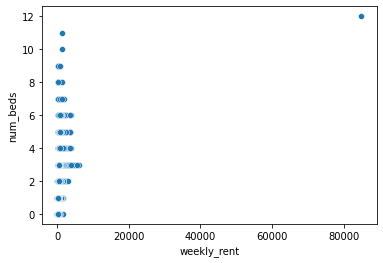

In [287]:
sns.scatterplot(data=df, x="weekly_rent", y="num_beds")

Immidiately we see a point which is obviously an outlier. It's weekly cost is far too high.

Start by filtering out anything above 5 standard deviations in price from the mean.

In [288]:
mean = df["weekly_rent"].mean()
std = df["weekly_rent"].std()
df = df[df["weekly_rent"] <= mean + 2*std]

<AxesSubplot:xlabel='weekly_rent', ylabel='num_beds'>

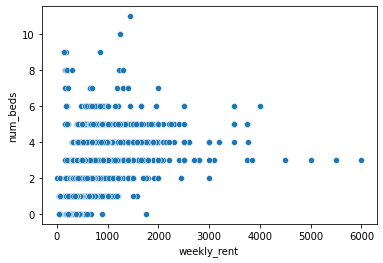

In [289]:
sns.scatterplot(data=df, x="weekly_rent", y="num_beds")

We still see a small number of high, outlier properties with 2.5k+ weekly rents.

In [290]:
ss = StandardScaler()
df = pd.DataFrame(ss.fit_transform(df), columns = ["weekly_rent", "num_beds"])

<AxesSubplot:xlabel='weekly_rent', ylabel='num_beds'>

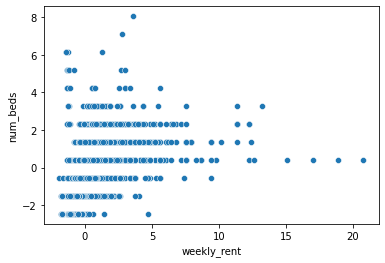

In [291]:
sns.scatterplot(data=df, x="weekly_rent", y="num_beds")

Based on this plot it looks like there is a single cluster. From out observations we know that some properties are listed at lowprices, but very high num_beds.
These are typically share houses, and will throw off the analysis.

In [292]:
cluster = KMeans(n_clusters = 4)
df = df.fillna(0) # MAYBE REMOVE NAN VALUES INSTEAD
model = cluster.fit(df)

<AxesSubplot:xlabel='weekly_rent', ylabel='num_beds'>

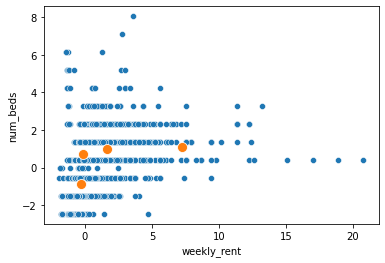

In [293]:
centroid = model.cluster_centers_
sns.scatterplot(data=df, x="weekly_rent", y="num_beds")
sns.scatterplot(x=model.cluster_centers_[:,0], y=model.cluster_centers_[0:,1], s= 100)

In [294]:

df["label"] = model.labels_
df["distance"] = distance(df["weekly_rent"], df["num_beds"], df["label"])

In [295]:
df["outlier"] = False
df.loc[df["distance"] > 3, "outlier"] = True

<AxesSubplot:xlabel='weekly_rent', ylabel='num_beds'>

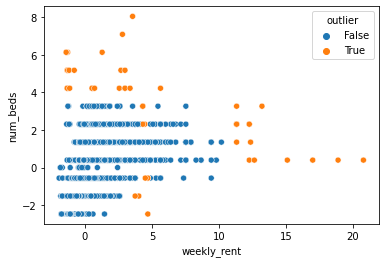

In [296]:
sns.scatterplot(data=df, x="weekly_rent", y="num_beds", hue = "outlier")

This works, but I'm not sure its ideal.

# PCA clustering

In [297]:
from sklearn.decomposition import PCA

In [298]:
df = pd.read_csv(f"{DIR_CUR}pre_processed_data.csv")[["weekly_rent", "bond", "num_beds", "num_baths", "num_parking", "school_distance"]]
mean = df["weekly_rent"].mean()
std = df["weekly_rent"].std()
df = df[df["weekly_rent"] <= mean + 2*std]
ss = StandardScaler()
sdf = pd.DataFrame(ss.fit_transform(df), columns = ["weekly_rent", "bond", "num_beds", "num_baths", "num_parking", "school_distance"])
sdf = sdf.fillna(0)
pca = PCA(n_components=2)
X = pca.fit_transform(sdf)

/home/dylan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

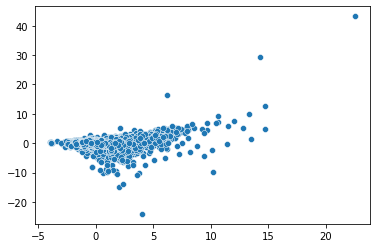

In [299]:
sns.scatterplot(X[:,0], X[:,1])

In [300]:
cluster = KMeans(n_clusters = 3)
model = cluster.fit(X)

/home/dylan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

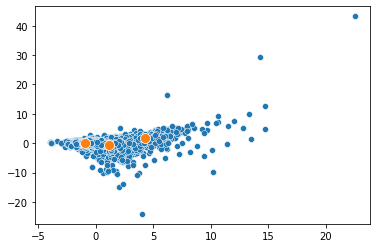

In [301]:
centroid = model.cluster_centers_
sns.scatterplot(X[:,0], X[:,1])
sns.scatterplot(x=model.cluster_centers_[:,0], y=model.cluster_centers_[0:,1], s= 100)

In [302]:
labels = model.labels_
sdf["distance"] = distance(X[:,0], X[:,1], labels)

<AxesSubplot:xlabel='weekly_rent', ylabel='num_beds'>

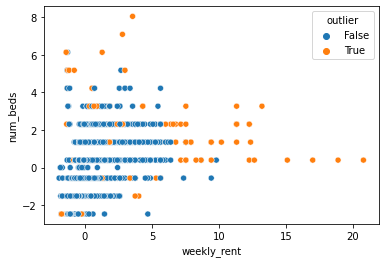

In [303]:

sdf["outlier"] = False
sdf.loc[sdf["distance"] > 2.5, "outlier"] = True
sns.scatterplot(data=sdf, x="weekly_rent", y="num_beds", hue = "outlier")

In [304]:
sdf.loc[sdf["outlier"] == True]
print(len(sdf), len(df))
df.reset_index().loc[sdf["outlier"] == True]

14648 14648


,index,weekly_rent,bond,num_beds,num_baths,num_parking,school_distance
37,37,450.0,1950.0,4.0,2.0,2.0,8067.5
75,76,360.0,1564.0,3.0,2.0,1.0,10908.1
96,97,2300.0,13800.0,4.0,2.0,1.0,822.5
131,135,830.0,3607.0,6.0,3.0,2.0,2072.5
140,144,450.0,1950.0,4.0,2.0,4.0,18584.1
...,...,...,...,...,...,...,...
14400,15012,450.0,1950.0,4.0,2.0,2.0,11272.4
14503,15120,380.0,1651.0,3.0,2.0,2.0,10809.5
14565,15183,1200.0,5214.0,2.0,2.0,1.0,170.3
14576,15195,995.0,4324.0,4.0,2.0,1.0,8017.5


We can see this is equally bad. These should not all be outliers.

# Regression Analysis

In [305]:
df = pd.read_csv(f"{DIR_CUR}pre_processed_data.csv")
df = df.fillna(0)
mean = df["weekly_rent"].mean()
std = df["weekly_rent"].std()
df = df[df["weekly_rent"] <= mean + 2*std]
predictors = ["num_beds", "num_baths", "num_parking", "school_distance"]
target = ["weekly_rent"]

In [306]:
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.regression.linear_model as lm
model = lm.OLS(df[target], df[predictors])

In [307]:
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            weekly_rent   R-squared (uncentered):                   0.778
Model:                            OLS   Adj. R-squared (uncentered):              0.778
Method:                 Least Squares   F-statistic:                          1.336e+04
Date:                Thu, 15 Sep 2022   Prob (F-statistic):                        0.00
Time:                        16:26:49   Log-Likelihood:                     -1.0689e+05
No. Observations:               15269   AIC:                                  2.138e+05
Df Residuals:                   15265   BIC:                                  2.138e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [308]:
influence = OLSInfluence(results)
sres = influence.resid_studentized_internal
print(sres.idxmin(), sres.min())

12945 -9.954774032411017


/home/dylan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


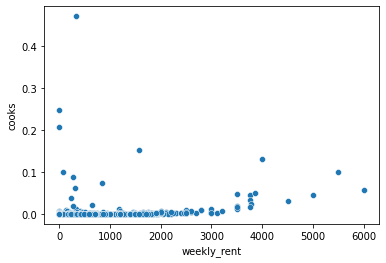

In [309]:
df["sres"] = sres
df["cooks"] = influence.cooks_distance[0]
fig = sns.scatterplot(df["weekly_rent"], df["cooks"])

<AxesSubplot:xlabel='weekly_rent', ylabel='num_beds'>

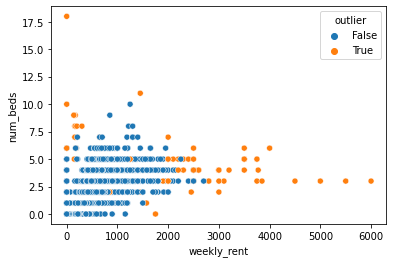

In [310]:
df["outlier"] = False
df.loc[df["cooks"] > 0.002, "outlier"] = True 
sns.scatterplot(data=df, x="weekly_rent", y="num_beds", hue = "outlier")

In [311]:
df[df["outlier"] == True]

,url,postcode,weekly_rent,bond,num_beds,num_baths,num_parking,internal_area_m^2,land_area_m^2,last_sold,...,demographic_family,demographic_single,demographic_average_age,latitude,longitude,school_duration,school_distance,sres,cooks,outlier
97,https://www.domain.com.au/12-clendon-court-too...,3142.0,2300.0,13800.0,4.0,2.0,1.0,0.0,0.0,0.0,...,0.48,0.52,0,-37.844436,145.017664,1.475000,822.5,6.132302,0.002171,True
101,https://www.domain.com.au/380-tower-road-porta...,3223.0,1750.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0,-38.127173,144.671610,3.340000,2903.9,5.993057,0.004211,True
233,https://www.domain.com.au/48-50-fogarty-ave-hi...,3216.0,250.0,1083.0,2.0,4.0,0.0,0.0,0.0,2013.0,...,0.55,0.45,40 to 59,-38.193425,144.309198,3.720000,1838.0,-2.426023,0.002964,True
329,https://www.domain.com.au/5401-464-collins-str...,3000.0,2500.0,15000.0,3.0,3.0,2.0,0.0,0.0,0.0,...,0.24,0.76,20 to 39,-37.817560,144.958592,0.955000,451.6,6.418771,0.005337,True
528,https://www.domain.com.au/9-lansdowne-street-b...,3942.0,5000.0,2500.0,3.0,2.0,3.0,0.0,700.0,2017.0,...,0.58,0.42,0,-38.372703,144.785690,6.150000,4614.7,16.723170,0.044886,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14600,https://www.domain.com.au/1-20-kent-avenue-bri...,3186.0,3500.0,0.0,5.0,4.0,3.0,0.0,0.0,2008.0,...,0.54,0.46,40 to 59,-37.895941,144.986729,3.098333,1265.6,8.931991,0.012159,True
14743,https://www.domain.com.au/210-staceys-road-ana...,3213.0,850.0,3694.0,2.0,1.0,31.0,0.0,0.0,2009.0,...,0.57,0.43,40 to 59,-38.010638,144.328740,6.981667,7492.4,1.982586,0.073537,True
14761,https://www.domain.com.au/46-48-wells-road-bea...,3193.0,2500.0,10863.0,5.0,3.0,2.0,0.0,1056.0,2016.0,...,0.60,0.40,40 to 59,-37.983764,145.049996,1.453333,742.2,5.872633,0.002708,True
14793,https://www.domain.com.au/163-victoria-parade-...,3065.0,2000.0,8690.0,7.0,2.0,2.0,0.0,0.0,2010.0,...,0.25,0.75,20 to 39,-37.808286,144.980481,1.201667,553.5,4.146472,0.005416,True


Maybe legit??

In [3]:
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.regression.linear_model as lm

df = pd.read_csv(f"../data/curated/pre_processed_data.csv")

# Remove any value with a weekly rent past 2 standard deviations. (this just removes extreme outliers where data has been input incorrectly)
mean = df["weekly_rent"].mean()
std = df["weekly_rent"].std()
df = df[df["weekly_rent"] <= mean + 2*std]

df2 = df.copy()

# Define the independent variables
predictors = ["num_beds", "num_baths", "num_parking", "school_distance"]
# Define the dependent variabe
target = ["weekly_rent"]
# Remove NaN values
df[predictors] = df[predictors].fillna(df[predictors].mean())
df[target] = df[target].fillna(df[target].mean())


# Fit an ordinary linear model
model = lm.OLS(df[target], df[predictors])
results = model.fit()
influence = OLSInfluence(results)
# Get the standardised residuals
sres = influence.resid_studentized_internal

# mark points above a certain cooks distance.
df2.loc[influence.cooks_distance[0] < 0.002].to_csv(f"../data/curated/outlier_removed_data.csv")

In [ ]:
#